In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

2025-10-29 00:55:08.020738: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-29 00:55:08.117428: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-29 00:55:09.868166: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
def fetch_stock_data(ticker, start_date='2015-01-01', end_date='2025-09-10'):
    """
    Fetch historical stock data from Yahoo Finance

    Parameters:
    - ticker: Stock ticker symbol (e.g., 'AAPL', 'RELIANCE.NS', 'TCS.BO')
    - start_date: Start date for historical data
    - end_date: End date for historical data

    Returns:
    - DataFrame with stock data
    """
    try:
        # Download data
        data = yf.download(ticker, start=start_date, end=end_date, progress=False)

        if data.empty:
            print(f"No data found for {ticker}")
            return None

        # Add technical indicators
        data['MA_7'] = data['Close'].rolling(window=7).mean()
        data['MA_21'] = data['Close'].rolling(window=21).mean()
        data['MA_50'] = data['Close'].rolling(window=50).mean()

        # Volatility
        data['Volatility'] = data['Close'].rolling(window=21).std()

        # Daily returns
        data['Returns'] = data['Close'].pct_change()

        # Drop NaN values
        data = data.dropna()

        print(f"Successfully fetched {len(data)} records for {ticker}")
        print(f"Date range: {data.index[0]} to {data.index[-1]}")

        return data
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

In [3]:
def prepare_data(data, look_back=60, target_col='Close'):
    """
    Prepare data for LSTM/GRU training

    Parameters:
    - data: DataFrame with stock data
    - look_back: Number of previous time steps to use for prediction
    - target_col: Column to predict

    Returns:
    - X_train, X_test, y_train, y_test, scaler
    """
    # Select features
    features = ['Close', 'Volume', 'MA_7', 'MA_21', 'MA_50', 'Volatility']
    df = data[features].copy()

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df)

    # Create sequences
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i])
        y.append(scaled_data[i, 0])  # Predict Close price (first column)

    X, y = np.array(X), np.array(y)

    # Split into train and test (80-20 split)
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")
    print(f"Input shape: {X_train.shape}")

    return X_train, X_test, y_train, y_test, scaler, features

In [4]:
def build_lstm_model(input_shape, units=50, dropout=0.2):
    """
    Build LSTM model for stock prediction

    Parameters:
    - input_shape: Shape of input data (time_steps, features)
    - units: Number of LSTM units
    - dropout: Dropout rate for regularization

    Returns:
    - Compiled LSTM model
    """
    model = Sequential([
        LSTM(units=units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout),
        LSTM(units=units, return_sequences=True),
        Dropout(dropout),
        LSTM(units=units, return_sequences=False),
        Dropout(dropout),
        Dense(units=25),
        Dense(units=1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    print("LSTM Model Architecture:")
    model.summary()

    return model

In [5]:
def build_gru_model(input_shape, units=50, dropout=0.2):
    """
    Build GRU model for stock prediction

    Parameters:
    - input_shape: Shape of input data (time_steps, features)
    - units: Number of GRU units
    - dropout: Dropout rate for regularization

    Returns:
    - Compiled GRU model
    """
    model = Sequential([
        GRU(units=units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout),
        GRU(units=units, return_sequences=True),
        Dropout(dropout),
        GRU(units=units, return_sequences=False),
        Dropout(dropout),
        Dense(units=25),
        Dense(units=1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    print("GRU Model Architecture:")
    model.summary()

    return model

In [6]:
def train_model(model, X_train, y_train, X_test, y_test, epochs=50, batch_size=32, model_name='model'):
    """
    Train the model with early stopping

    Parameters:
    - model: Keras model
    - X_train, y_train: Training data
    - X_test, y_test: Validation data
    - epochs: Number of training epochs
    - batch_size: Batch size
    - model_name: Name for saving model

    Returns:
    - Trained model, training history
    """
    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    checkpoint = ModelCheckpoint(f'{model_name}.keras', monitor='val_loss', save_best_only=True, mode='min')

    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop, checkpoint],
        verbose=1
    )

    print(f"\nTraining completed. Best model saved as {model_name}.keras")

    return model, history

In [7]:
def evaluate_model(model, X_test, y_test, scaler, features):
    """
    Evaluate model performance

    Parameters:
    - model: Trained model
    - X_test, y_test: Test data
    - scaler: Scaler used for normalization
    - features: List of feature names

    Returns:
    - predictions, metrics dictionary
    """
    # Make predictions
    y_pred = model.predict(X_test, verbose=0)

    # Inverse transform predictions
    # Create dummy array for inverse transform
    dummy = np.zeros((len(y_pred), len(features)))
    dummy[:, 0] = y_pred.flatten()
    y_pred_rescaled = scaler.inverse_transform(dummy)[:, 0]

    # Inverse transform actual values
    dummy[:, 0] = y_test
    y_test_rescaled = scaler.inverse_transform(dummy)[:, 0]

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)
    mape = np.mean(np.abs((y_test_rescaled - y_pred_rescaled) / y_test_rescaled)) * 100

    metrics = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape
    }

    print(f"\nModel Evaluation Metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")

    return y_pred_rescaled, y_test_rescaled, metrics

## Visualization Functions

In [8]:
def plot_training_history(history, model_name):
    """Plot training and validation loss"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title(f'{model_name} - Training History (Loss)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # MAE
    ax2.plot(history.history['mae'], label='Training MAE')
    ax2.plot(history.history['val_mae'], label='Validation MAE')
    ax2.set_title(f'{model_name} - Training History (MAE)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MAE')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(f'{model_name}_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_predictions(y_test, y_pred, model_name):
    """Plot actual vs predicted prices"""
    plt.figure(figsize=(15, 6))
    plt.plot(y_test, label='Actual Price', linewidth=2)
    plt.plot(y_pred, label='Predicted Price', linewidth=2, alpha=0.7)
    plt.title(f'{model_name} - Actual vs Predicted Stock Prices')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{model_name}_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_residuals(y_test, y_pred, model_name):
    """Plot residual analysis"""
    residuals = y_test - y_pred

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Residual plot
    ax1.scatter(y_pred, residuals, alpha=0.5)
    ax1.axhline(y=0, color='r', linestyle='--')
    ax1.set_title(f'{model_name} - Residual Plot')
    ax1.set_xlabel('Predicted Price')
    ax1.set_ylabel('Residuals')
    ax1.grid(True, alpha=0.3)

    # Residual distribution
    ax2.hist(residuals, bins=50, edgecolor='black')
    ax2.set_title(f'{model_name} - Residual Distribution')
    ax2.set_xlabel('Residuals')
    ax2.set_ylabel('Frequency')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{model_name}_residuals.png', dpi=300, bbox_inches='tight')
    plt.show()

## Training Pipeline

Fetching data for RELIANCE.NS...
Fetched 2417 records for RELIANCE.NS from 2015-03-16 00:00:00 to 2024-12-30 00:00:00

Preparing data...
Train samples: 1885, Test samples: 472
Input shape: (1885, 60, 6)

Training LSTM Model


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 60, 50)         │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,101 (207.43 KB)

 Trainable params: 53,101 (207.43 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.0122 - mae: 0.0687 - val_loss: 0.0054 - val_mae: 0.0601
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0029 - mae: 0.0359 - val_loss: 0.0019 - val_mae: 0.0358
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mae: 0.0304 - val_loss: 0.0031 - val_mae: 0.0457
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mae: 0.0294 - val_loss: 0.0039 - val_mae: 0.0521
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mae: 0.0283 - val_loss: 0.0032 - val_mae: 0.0467
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mae: 0.0294 - val_loss: 0.0031 - val_mae: 0.0459
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mae: 0.0267 - val_loss: 0.0038 - val_mae: 0.0524
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - mae: 0.0264 - val_loss: 0.0011 - val_mae: 0.0271
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - mae

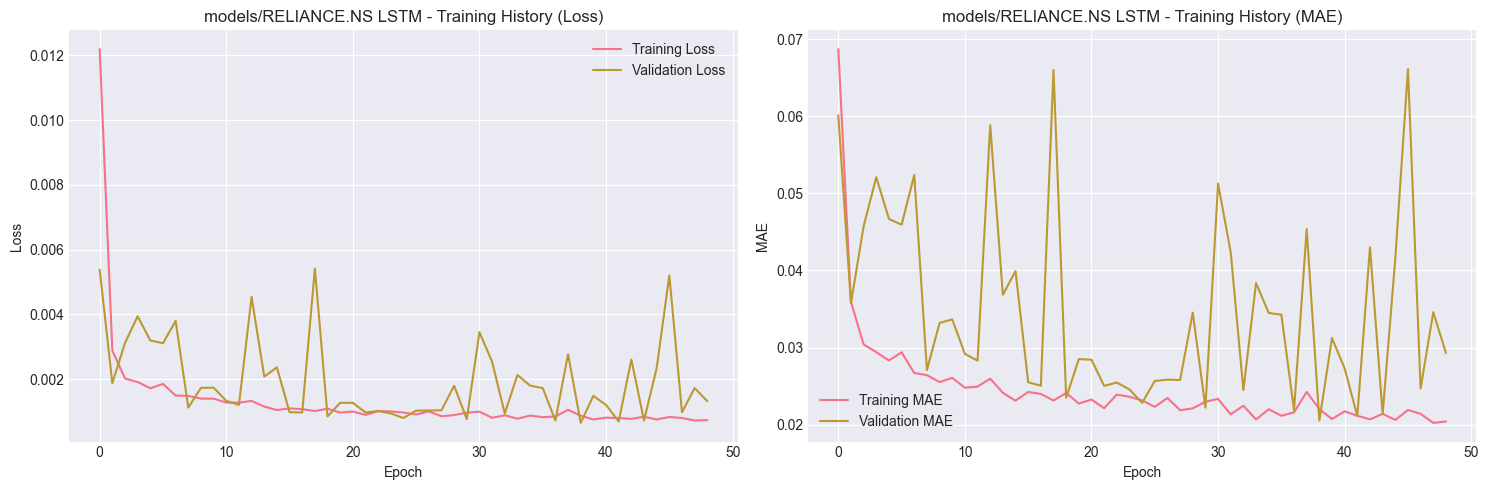

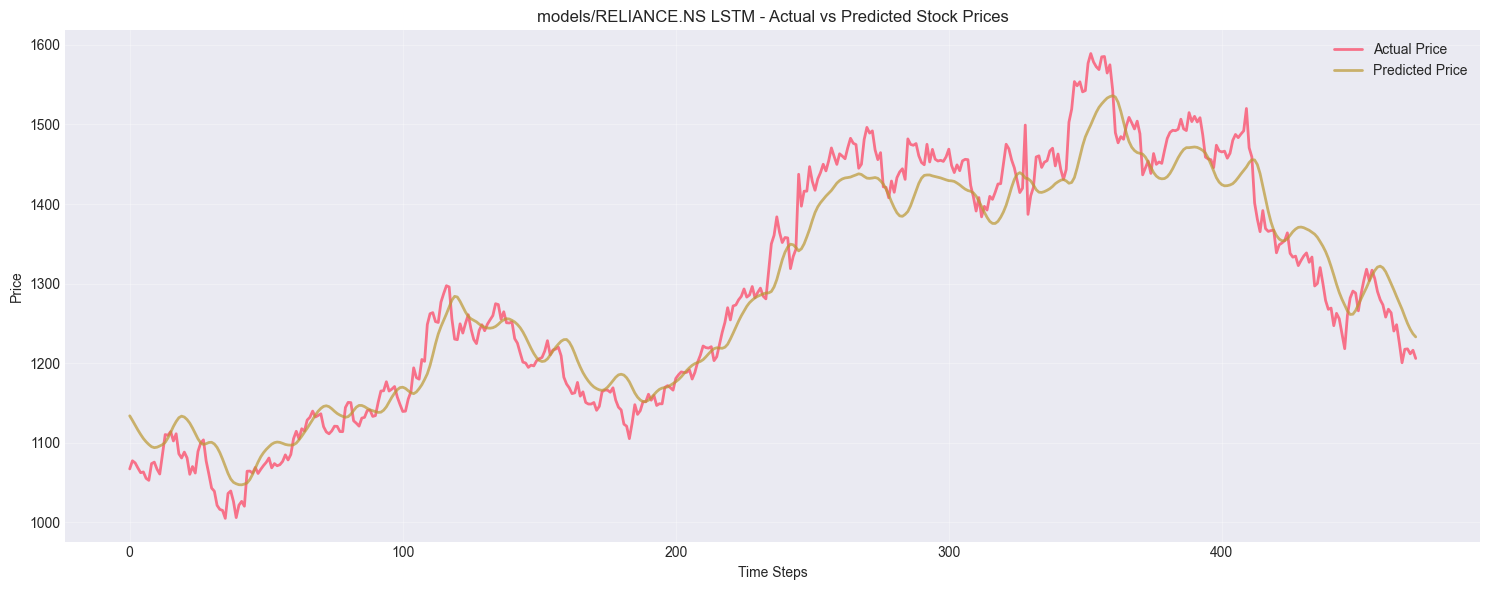

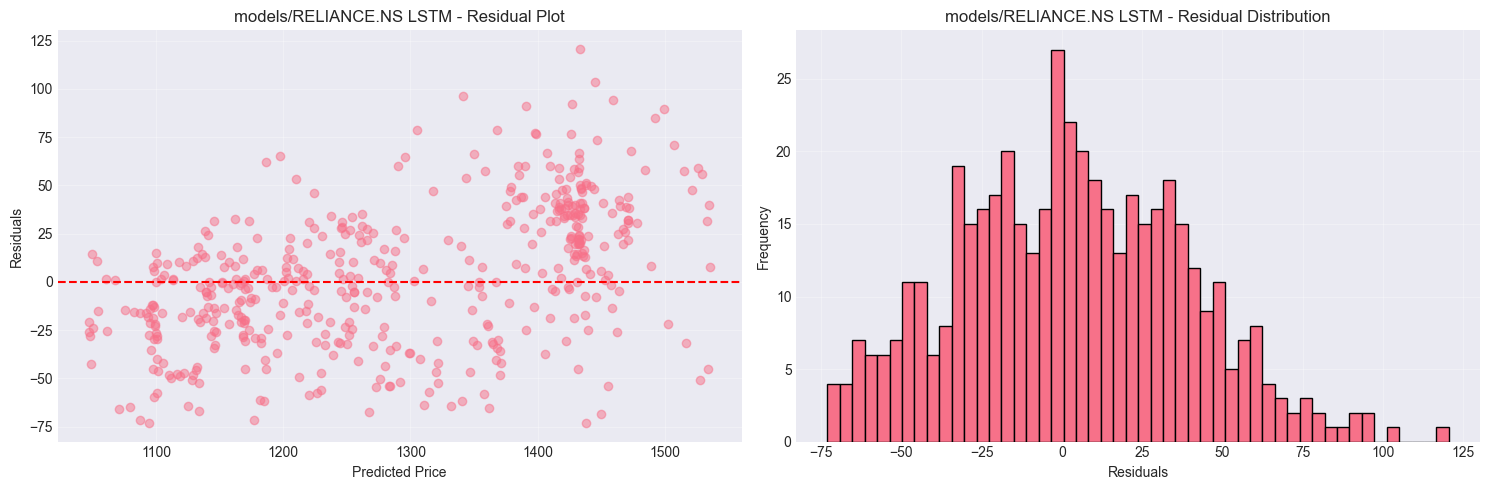


Training GRU Model


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, 60, 50)         │         8,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 60, 50)         │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,601 (158.60 KB)

 Trainable params: 40,601 (158.60 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0122 - mae: 0.0688 - val_loss: 0.0023 - val_mae: 0.0394
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mae: 0.0401 - val_loss: 0.0018 - val_mae: 0.0352
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mae: 0.0332 - val_loss: 7.4696e-04 - val_mae: 0.0220
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021 - mae: 0.0309 - val_loss: 0.0010 - val_mae: 0.0261
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mae: 0.0303 - val_loss: 7.2123e-04 - val_mae: 0.0214
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mae: 0.0285 - val_loss: 8.1939e-04 - val_mae: 0.0231
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mae: 0.0266 - val_loss: 5.7991e-04 - val_mae: 0.0192
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - mae: 0.0247 - val_loss: 5.5521e-04 - val_mae: 0.0187
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step -

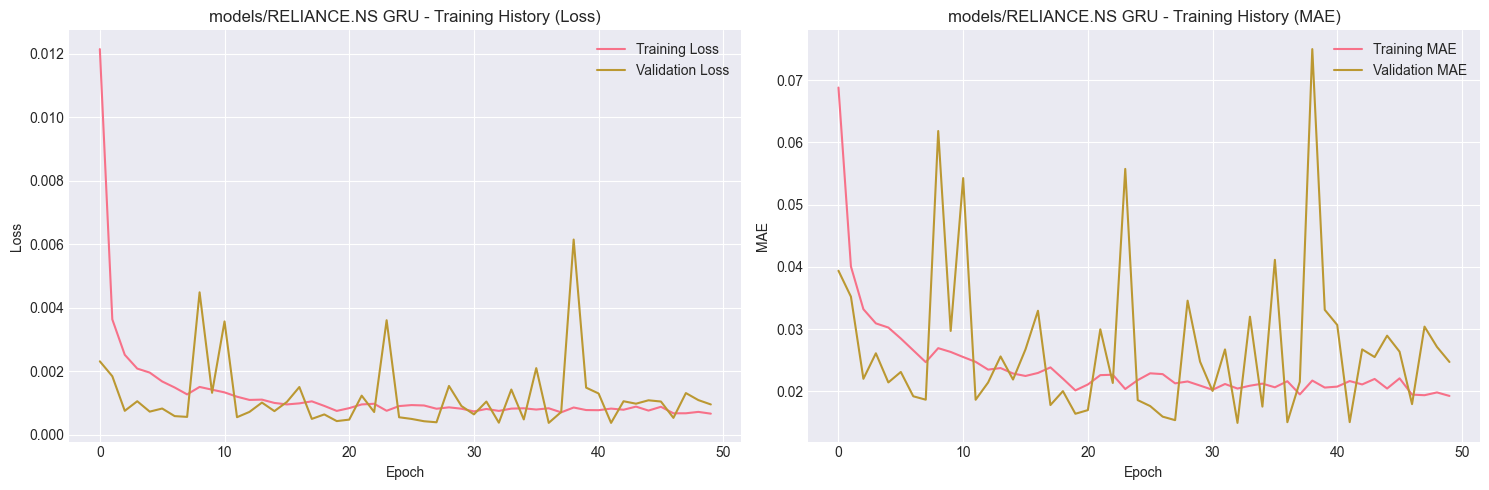

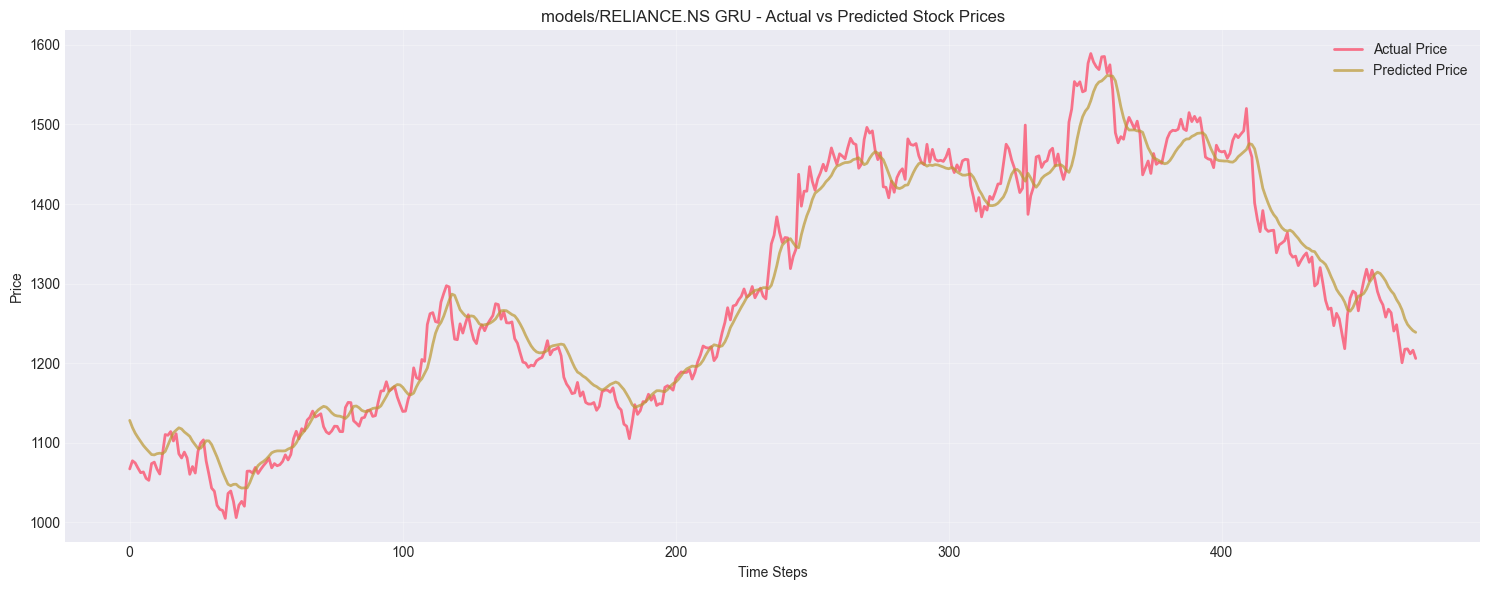

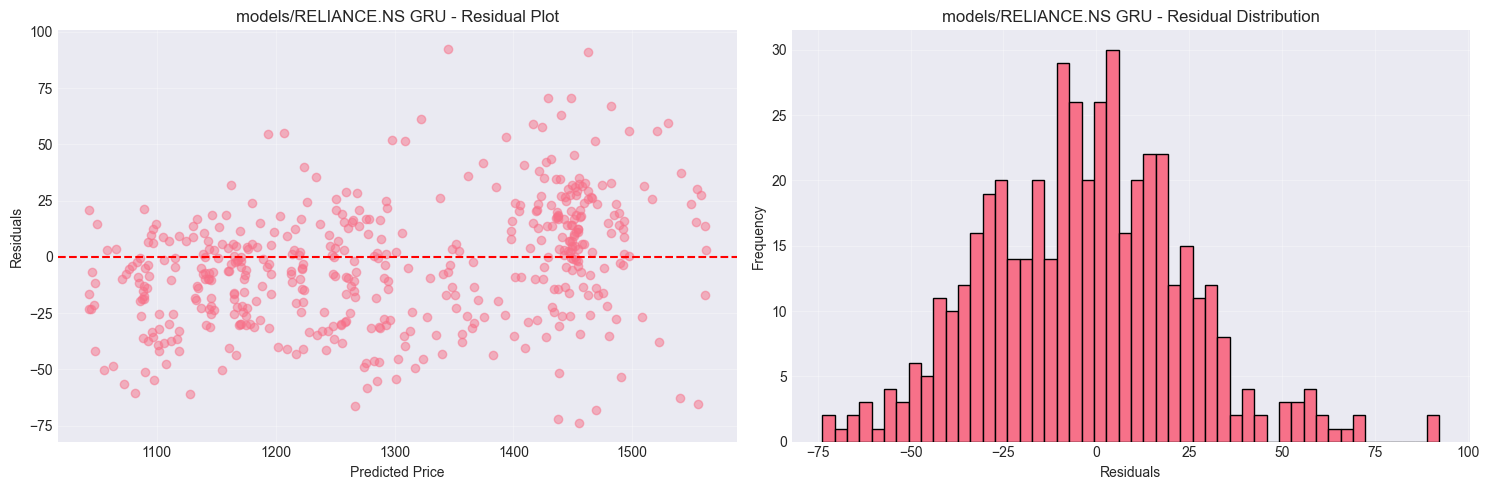


Model Comparison
  Metric      LSTM       GRU
    RMSE 35.965057 27.085270
     MAE 29.048102 21.325928
      R²  0.944551  0.968552
MAPE (%)  2.232192  1.662999

Scaler and metadata saved successfully in 'models' directory!

Training complete! You can now use the trained models in the Streamlit app.


In [10]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ========== Configuration ==========
TICKER = 'RELIANCE.NS'  # Change to your stock ticker: 'RELIANCE.NS' for NSE, 'TCS.BO' for BSE
START_DATE = '2015-01-01'
END_DATE = '2024-12-31'
LOOK_BACK = 60
EPOCHS = 50
BATCH_SIZE = 32

MODEL_DIR = 'models'  # Directory to save models and scalers

# Create directory if it doesn't exist
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

# ===== Functions =====

def fetch_stock_data(ticker, start_date=START_DATE, end_date=END_DATE):
    try:
        data = yf.download(ticker, start=start_date, end=end_date, progress=False)
        if data.empty:
            print(f"No data found for {ticker}")
            return None
        data['MA_7'] = data['Close'].rolling(window=7).mean()
        data['MA_21'] = data['Close'].rolling(window=21).mean()
        data['MA_50'] = data['Close'].rolling(window=50).mean()
        data['Volatility'] = data['Close'].rolling(window=21).std()
        data['Returns'] = data['Close'].pct_change()
        data = data.dropna()
        print(f"Fetched {len(data)} records for {ticker} from {data.index[0]} to {data.index[-1]}")
        return data
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

def prepare_data(data, look_back=LOOK_BACK):
    features = ['Close', 'Volume', 'MA_7', 'MA_21', 'MA_50', 'Volatility']
    df = data[features].copy()
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df)

    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i])
        y.append(scaled_data[i, 0])  # Predict Close price

    X, y = np.array(X), np.array(y)
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")
    print(f"Input shape: {X_train.shape}")
    return X_train, X_test, y_train, y_test, scaler, features

def build_lstm_model(input_shape, units=50, dropout=0.2):
    model = Sequential([
        LSTM(units=units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout),
        LSTM(units=units, return_sequences=True),
        Dropout(dropout),
        LSTM(units=units, return_sequences=False),
        Dropout(dropout),
        Dense(units=25),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    model.summary()
    return model

def build_gru_model(input_shape, units=50, dropout=0.2):
    model = Sequential([
        GRU(units=units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout),
        GRU(units=units, return_sequences=True),
        Dropout(dropout),
        GRU(units=units, return_sequences=False),
        Dropout(dropout),
        Dense(units=25),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    model.summary()
    return model

def train_model(model, X_train, y_train, X_test, y_test, epochs=EPOCHS, batch_size=BATCH_SIZE, model_name='model'):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    checkpoint = ModelCheckpoint(f'{model_name}.keras', monitor='val_loss', save_best_only=True, mode='min')
    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stop, checkpoint],
                        verbose=1)
    print(f"Training completed. Best model saved as {model_name}.keras")
    return model, history

def evaluate_model(model, X_test, y_test, scaler, features):
    y_pred = model.predict(X_test, verbose=0)
    dummy = np.zeros((len(y_pred), len(features)))
    dummy[:, 0] = y_pred.flatten()
    y_pred_rescaled = scaler.inverse_transform(dummy)[:, 0]
    dummy[:, 0] = y_test
    y_test_rescaled = scaler.inverse_transform(dummy)[:, 0]
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)
    mape = np.mean(np.abs((y_test_rescaled - y_pred_rescaled) / y_test_rescaled)) * 100
    metrics = {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}

    print("\nModel Evaluation Metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")
    return y_pred_rescaled, y_test_rescaled, metrics

def plot_training_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title(f'{model_name} - Training History (Loss)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    ax2.plot(history.history['mae'], label='Training MAE')
    ax2.plot(history.history['val_mae'], label='Validation MAE')
    ax2.set_title(f'{model_name} - Training History (MAE)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MAE')
    ax2.legend()
    ax2.grid(True)
    plt.tight_layout()
    plt.savefig(f'{model_name}_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_predictions(y_test, y_pred, model_name):
    plt.figure(figsize=(15, 6))
    plt.plot(y_test, label='Actual Price', linewidth=2)
    plt.plot(y_pred, label='Predicted Price', linewidth=2, alpha=0.7)
    plt.title(f'{model_name} - Actual vs Predicted Stock Prices')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{model_name}_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_residuals(y_test, y_pred, model_name):
    residuals = y_test - y_pred
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.scatter(y_pred, residuals, alpha=0.5)
    ax1.axhline(y=0, color='r', linestyle='--')
    ax1.set_title(f'{model_name} - Residual Plot')
    ax1.set_xlabel('Predicted Price')
    ax1.set_ylabel('Residuals')
    ax1.grid(True, alpha=0.3)
    ax2.hist(residuals, bins=50, edgecolor='black')
    ax2.set_title(f'{model_name} - Residual Distribution')
    ax2.set_xlabel('Residuals')
    ax2.set_ylabel('Frequency')
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{model_name}_residuals.png', dpi=300, bbox_inches='tight')
    plt.show()

# ====== Run Training Pipeline ======

if __name__ == "__main__":
    print(f"Fetching data for {TICKER}...")
    data = fetch_stock_data(TICKER, START_DATE, END_DATE)

    if data is not None:
        print("\nPreparing data...")
        X_train, X_test, y_train, y_test, scaler, features = prepare_data(data, look_back=LOOK_BACK)

        print("\n" + "="*50)
        print("Training LSTM Model")
        print("="*50)
        lstm_model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))
        lstm_model, lstm_history = train_model(lstm_model, X_train, y_train, X_test, y_test,
                                               epochs=EPOCHS, batch_size=BATCH_SIZE,
                                               model_name=os.path.join(MODEL_DIR, f'{TICKER}_lstm_model'))

        print("\nEvaluating LSTM model...")
        lstm_pred, y_test_actual, lstm_metrics = evaluate_model(lstm_model, X_test, y_test, scaler, features)

        plot_training_history(lstm_history, os.path.join(MODEL_DIR, f'{TICKER} LSTM'))
        plot_predictions(y_test_actual, lstm_pred, os.path.join(MODEL_DIR, f'{TICKER} LSTM'))
        plot_residuals(y_test_actual, lstm_pred, os.path.join(MODEL_DIR, f'{TICKER} LSTM'))

        print("\n" + "="*50)
        print("Training GRU Model")
        print("="*50)
        gru_model = build_gru_model(input_shape=(X_train.shape[1], X_train.shape[2]))
        gru_model, gru_history = train_model(gru_model, X_train, y_train, X_test, y_test,
                                             epochs=EPOCHS, batch_size=BATCH_SIZE,
                                             model_name=os.path.join(MODEL_DIR, f'{TICKER}_gru_model'))

        print("\nEvaluating GRU model...")
        gru_pred, y_test_actual, gru_metrics = evaluate_model(gru_model, X_test, y_test, scaler, features)

        plot_training_history(gru_history, os.path.join(MODEL_DIR, f'{TICKER} GRU'))
        plot_predictions(y_test_actual, gru_pred, os.path.join(MODEL_DIR, f'{TICKER} GRU'))
        plot_residuals(y_test_actual, gru_pred, os.path.join(MODEL_DIR, f'{TICKER} GRU'))

        # Model comparison
        print("\n" + "="*50)
        print("Model Comparison")
        print("="*50)
        comparison_df = pd.DataFrame({
            'Metric': ['RMSE', 'MAE', 'R²', 'MAPE (%)'],
            'LSTM': [lstm_metrics['RMSE'], lstm_metrics['MAE'], lstm_metrics['R2'], lstm_metrics['MAPE']],
            'GRU': [gru_metrics['RMSE'], gru_metrics['MAE'], gru_metrics['R2'], gru_metrics['MAPE']]
        })
        print(comparison_df.to_string(index=False))

        # Save scaler and metadata
        scaler_path = os.path.join(MODEL_DIR, f'{TICKER}_scaler.pkl')
        metadata_path = os.path.join(MODEL_DIR, f'{TICKER}_metadata.pkl')

        joblib.dump(scaler, scaler_path)
        metadata = {
            'ticker': TICKER,
            'look_back': LOOK_BACK,
            'features': features,
            'lstm_metrics': lstm_metrics,
            'gru_metrics': gru_metrics
        }
        joblib.dump(metadata, metadata_path)

        print(f"\nScaler and metadata saved successfully in '{MODEL_DIR}' directory!")
        print("\nTraining complete! You can now use the trained models in the Streamlit app.")
